## Sentiment analysis using tweets in Croatian
- tweets are translated to english
- words in the tweet are represented by pre-trained word2vec embedding
- mean vector of words in a tweet are used as input features
- models are trained and tested

#### Import libraries

In [0]:
import pandas as pd # for data handling
import numpy as np # for linear algebra
import time # for timing
import matplotlib.pyplot as plt # for plotting

from gensim.models import KeyedVectors # for pre-trained embedding 

from sklearn.model_selection import train_test_split # for reserving test data

# metrics for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# sklearn classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf # for neural networks

#### Load pre-trained word2vec model

In [2]:
# Retrieve embedding file using wget
# use this if embedding file is not available locally
URL = "https://s3.amazonaws.com/dl4j-distribution/" # source url
FILE = "GoogleNews-vectors-negative300.bin.gz" # source file name
SOURCE = URL+FILE # source for embedding file
DIR = "/root/input/" # directory
! wget -P "$DIR" -c "$SOURCE" # retrieve embedding file

--2019-05-16 14:13:18--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.144.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.144.101|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [3]:
# Load pre-trained word2vec model from embedding file
EMBEDDING_FILE = DIR + FILE 
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Define vocabulary and embedding_size
vocabulary = set(word2vec.index2word) # set of words in vocabulary
embedding_size = word2vec.vector_size # dimension of word vector
print("Model contains %d words" %len(vocabulary))
print("Each word is represented by a %d dimensional vector" %embedding_size)

Model contains 3000000 words
Each word is represented by a 300 dimensional vector


#### Read data file with labeled tweets

In [4]:
DATAFILE = "croatian_cl.csv" # data file with labeled tweets
df = pd.read_csv(DATAFILE) # read file

# get tweets and targets
tweets, targets = df.en.values, df.target.values

print('Number of tweets = %d.' %len(tweets))
print('Number of labels = %d.' %len(targets))

# check for missing values and distinct tweets
print("Number of missing tweets: %d." %(np.sum(pd.isnull(tweets))))
print("Number of distinct tweets = %d" %(df.en.nunique()))

Number of tweets = 3554.
Number of labels = 3554.
Number of missing tweets: 1241.
Number of distinct tweets = 1869


#### Define function to obtain vector representation of a tweet

In [0]:
def mean_vector(tweet):
  """Returns mean of vector representation words in tweet.
  Returns a vector of zeros if none of the words appear in vocabulary 
  See: https://github.com/USC-CSSL/DDR """
  zero = np.zeros((embedding_size,), dtype="float32") # for null tweet
  if pd.isnull(tweet): return zero # tweet missing
  words = [w for w in tweet.split() if w in vocabulary] # valid words
  if not words: return zero # no word in vocabulary
  return np.mean([word2vec[w] for w in words], axis=0)

#### Create a new dataframe with vector representations

In [6]:
cols = ['v_'+str(i) for i in range(embedding_size)] # column names
dfV = pd.DataFrame(list(map(mean_vector, tweets)), columns=cols) # new df
dfV.insert(0, 'target', df.target) # insert label for tweets
print('Representation has %d rows and %d columns' %dfV.shape)
dfV.to_csv("vectors_croatian.csv", index=False) # save as csv file
dfV.head() # display first 5 rows

Representation has 3554 rows and 301 columns


,target,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,v_15,v_16,v_17,v_18,v_19,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29,v_30,v_31,v_32,v_33,v_34,v_35,v_36,v_37,v_38,...,v_260,v_261,v_262,v_263,v_264,v_265,v_266,v_267,v_268,v_269,v_270,v_271,v_272,v_273,v_274,v_275,v_276,v_277,v_278,v_279,v_280,v_281,v_282,v_283,v_284,v_285,v_286,v_287,v_288,v_289,v_290,v_291,v_292,v_293,v_294,v_295,v_296,v_297,v_298,v_299
0,0,0.065150,0.009019,0.067179,-0.040919,-0.012410,-0.018280,0.009684,-0.134450,0.132100,0.074039,-0.049042,-0.054626,0.049611,0.055868,-0.001475,0.069340,-0.024841,0.050489,-0.006887,-0.004979,0.030070,0.118340,-0.060832,-0.050171,0.029507,-0.059858,-0.058272,0.081014,0.095500,0.015274,0.054428,-0.094330,-0.033971,-0.046718,0.024851,0.039581,-0.059804,0.017680,-0.021286,...,0.097619,-0.012993,0.059367,0.107656,0.056512,0.132039,-0.091136,-0.055033,-0.079895,-0.000422,0.068047,0.043874,0.056295,0.002947,0.163801,-0.003601,0.062683,-0.096575,-0.010091,-0.012889,0.030141,0.020559,-0.069656,0.062251,0.045340,0.048859,-0.082072,-0.016469,-0.011396,0.047234,-0.171183,0.040507,-0.103552,0.056279,0.008240,0.063232,-0.029500,-0.023102,0.063029,0.006251
1,0,0.047030,0.038298,0.050593,-0.014921,-0.019487,0.001080,0.012733,-0.126671,0.135160,0.020182,-0.032330,-0.042847,0.013057,0.079890,0.013024,0.045451,0.021217,0.058042,-0.033532,0.021067,0.022423,0.130007,-0.046575,-0.063240,0.043275,-0.040901,-0.065597,0.069824,0.093467,-0.014897,0.043349,-0.076003,-0.073219,-0.038868,0.008141,0.030405,-0.055598,0.003606,-0.008437,...,0.066193,-0.016632,0.057467,0.124671,0.018811,0.139160,-0.087874,-0.046190,-0.113563,-0.025668,0.056927,0.048382,0.051730,0.000430,0.138824,0.002920,0.036584,-0.107699,-0.008357,-0.025269,0.022621,-0.012037,-0.076594,0.036316,0.054698,0.029917,-0.076397,-0.025306,-0.013787,0.028464,-0.201397,0.022677,-0.098239,0.040318,-0.001202,0.060636,-0.025118,-0.056688,0.061768,-0.018038
2,0,0.011346,-0.007246,0.036150,0.069449,-0.058742,0.028303,0.021938,-0.074825,0.170131,0.054443,-0.057931,-0.105502,0.000706,0.026956,-0.083705,0.082903,0.018865,0.061611,-0.054331,-0.085449,-0.043265,-0.007756,0.001944,0.003996,-0.029933,0.025635,-0.111973,0.044713,-0.004205,0.029079,-0.014352,-0.005112,-0.034337,-0.009421,-0.001295,-0.046138,0.016440,-0.015268,0.038993,...,-0.015682,-0.029837,-0.032270,0.039398,-0.000750,0.162074,0.047036,-0.043206,-0.068412,-0.036375,0.005598,0.075383,0.084787,-0.001395,0.069188,-0.077698,-0.042717,-0.117074,0.001081,-0.031363,-0.003601,0.014319,-0.020796,0.052702,0.016894,0.021855,-0.038986,0.018559,0.040728,0.043115,-0.098458,0.033447,-0.101135,-0.017648,-0.030831,0.060713,-0.018651,-0.043719,0.074031,-0.026228
3,0,0.018066,0.219910,0.014183,-0.025162,-0.056625,-0.002243,-0.026909,-0.141098,0.039261,0.091843,0.033615,-0.044662,-0.044727,0.016409,-0.107941,0.002361,-0.055153,0.063171,-0.040625,-0.116760,-0.049404,0.114670,-0.082092,-0.033765,0.059723,-0.100128,-0.078390,0.114548,0.148252,-0.082382,-0.007370,0.067368,0.006516,0.038830,-0.033752,-0.085182,-0.019455,-0.037857,0.086548,...,-0.029911,-0.034008,-0.039093,-0.041992,0.149231,0.147850,-0.031239,0.034821,0.012558,0.023254,0.050354,0.055450,0.006393,0.026867,0.091095,-0.075897,-0.047775,-0.149414,0.024166,-0.057501,0.070264,0.043154,0.116257,-0.005800,0.003794,0.041729,-0.125759,0.128830,-0.031479,0.106674,-0.093201,-0.077744,-0.122597,-0.011139,-0.011780,-0.000778,-0.084488,-0.060814,0.055687,-0.043800
4,0,0.173340,-0.013428,0.019592,0.078735,0.087097,0.056946,0.200806,-0.009323,0.252197,0.140381,-0.087158,-0.221191,-0.051636,0.019287,0.007324,0.103516,0.214874,0.018066,0.073486,-0.094482,0.081177,0.180176,0.153564,0.158356,0.070801,0.078613,0.081657,0.079773,0.169434,-0.198730,-0.123535,-0.034668,0.101562,-0.085541,-0.024170,-0.014404,0.014404,-0.054688,0.015778,...,-0.034485,-0.000336,0.044128,0.052490,0.024902,0.158203,0.094971,0.130615,-0.042480,0.038574,0.196289,0.172363,0.107666,0.025391,0.097656,-0.173523,-0.036743,-

#### Reserve testing data

In [7]:
features = list(dfV)[1:]
X_train, X_test, y_train, y_test = train_test_split(
    dfV[features], dfV['target'], test_size=0.2, random_state=2019)
print("Training set contains %d examples" %len(X_train))
print("Test set contains %d examples" %len(X_test))
print("Number of input features = %d" %len(features))

Training set contains 2843 examples
Test set contains 711 examples
Number of input features = 300


In [8]:
# Check distribution of target in training and validation data
def classDistribution(y_train, y_test):
    """Returns distribution of classes in training and test data"""
    res, resCount = pd.DataFrame(), pd.DataFrame()
    res['train'] = y_train.value_counts(normalize=True, sort=False)
    res['test'] = y_test.value_counts(normalize=True, sort=False)
    resCount['train'] = y_train.value_counts(normalize=False, sort=False)
    resCount['test'] = y_test.value_counts(normalize=False, sort=False)
    return res.transpose(), resCount.transpose()

dist, count = classDistribution(y_train, y_test)
print('\nClass distribution in training and test data:')
print(dist)
print('\nClass counts in training and test data:')
print(count)


Class distribution in training and test data:
              0         1
train  0.404151  0.595849
test   0.388186  0.611814

Class counts in training and test data:
          0     1
train  1149  1694
test    276   435


#### Train and test models

##### Specify function for evaluating trained model on test data

In [0]:
def evaluateModel(y_test, predicted):
    """evaluates trained model"""
    acc = accuracy_score(y_test, predicted) # accuracy
    print("\nAccuracy with validation data: %4.2f%%" %(100*acc))
    print("\nClassification report:\n")
    print(classification_report(y_test, predicted)) 
    cm = confusion_matrix(y_test, predicted) # confusion_matrix
    print("\nConfusion matrix:\n")
    print(pd.DataFrame(cm))
    return acc

##### Specify models to use

In [0]:
models = {} # dictionary of Scikit-Learn classifiers with non-default parameters 
models['DT'] = DecisionTreeClassifier()
models['RF'] = RandomForestClassifier(n_estimators=100)
models['SVM'] = SVC(kernel='poly', gamma='scale')
models['KNN'] = KNeighborsClassifier(n_neighbors=3)
models['LRM'] = LogisticRegression(multi_class='auto', solver='lbfgs')

##### Train and test Scikit-Learn models

In [11]:
result = []
for m in [m for m in models]:
    model = models[m] # model to use
    print("\nTraining classifier %s:\n%s" %(m, model))
    st = time.time() # start time for training and testing
    model.fit(X_train, y_train) # train model
    predicted = model.predict(X_test) # predict test labels with trained model
    t = time.time() - st # time to train and test model
    print("Time to train and test classifier: %4.2f seconds" %(t))
    acc = evaluateModel(y_test, predicted) # evaluate prediction accuracy
    result.append([m, acc, t]) # record results
    print(60*'=') # end training and testing for model


Training classifier DT:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Time to train and test classifier: 0.55 seconds

Accuracy with validation data: 81.01%

Classification report:

              precision    recall  f1-score   support

           0       0.77      0.72      0.75       276
           1       0.83      0.86      0.85       435

   micro avg       0.81      0.81      0.81       711
   macro avg       0.80      0.79      0.80       711
weighted avg       0.81      0.81      0.81       711


Confusion matrix:

     0    1
0  200   76
1   59  376

Training classifier RF:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, m

,model,accuracy,time
0,DT,0.810127,0.546197
1,RF,0.879044,1.993088
2,SVM,0.880450,1.769954
3,KNN,0.827004,0.936793
4,LRM,0.853727,0.062253


##### Use single-layered tensorflow neural network (ANN)

In [0]:
# Define single-layered tensorflow neural network (ANN)
def ann(**kwargs):
    """Returns trained single layered network"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(kwargs['nFeatures'],)),
        tf.keras.layers.Dense(kwargs['nNeurons'], activation=tf.nn.relu),
        tf.keras.layers.Dropout(kwargs['dropOutRate']),
        tf.keras.layers.Dense(kwargs['nClasses'], activation=tf.nn.softmax)])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
# Specify model parameters for ANN
nNeurons = 128 # number of neurons in hidden layer
dropOutRate = 0.2 # drop out rate
nFeatures= embedding_size # number of input features
nClasses = 2 # number of output classes
nEpochs = 10 # number of training epochs

In [14]:
# Train and test ANN model
m = 'ANN' # model name
model = ann(nNeurons=nNeurons, dropOutRate=dropOutRate,
            nFeatures=nFeatures, nClasses=nClasses) # specify model
print(model.summary()) # display model summary
print("\nTraining classifier: %s" %m)
st = time.time() # start time for training and testing
hist = model.fit(X_train, y_train, epochs=nEpochs, validation_split=0.2) # train
predicted = model.predict(X_test) # predict test examples
predicted = np.argmax(predicted, axis=1) # most likely label
t = time.time() - st # time to train and test model
print("Time to train and test classifier: %4.2f seconds" %(t))
acc = evaluateModel(y_test, predicted) # evaluate prediction accuracy
result.append([m, acc, t]) # record results
print(60*'=') # end training and testing for model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               38528     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 38,786
Trainable params: 38,786
Non-trainable params: 0
_________________________________________________________________
None

Training classifier: ANN
Train on 2274 samples, validate on 569 samples
Epoch

In [0]:
# plot training and test accuracy
def plotHistorty(model, history):
    # plot history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(model+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

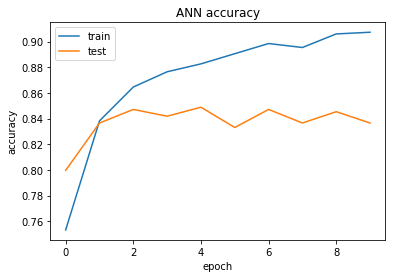

In [16]:
plotHistorty(m, hist)

##### Show results

In [17]:
pd.DataFrame(result, columns = ['model', 'accuracy', 'time']) # show results

,model,accuracy,time
0,DT,0.810127,0.546197
1,RF,0.879044,1.993088
2,SVM,0.880450,1.769954
3,KNN,0.827004,0.936793
4,LRM,0.853727,0.062253
5,ANN,0.857947,3.773772
